# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [ ]:
print(60*"*")
print(f"RUNNING NOTEBOOK 4")

In [ ]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

In [ ]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util

In [ ]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [ ]:
project = hopsworks.login()
fs = project.get_feature_store() 
# Get AQICN_API_KEY from settings (which reads from .env or environment variables)
secrets = hopsworks.get_secrets_api()
# Replace any existing secret with the new value

try:
    AQICN_API_KEY = settings.AQICN_API_KEY.get_secret_value() 
except:
    AQICN_API_KEY = os.getenv("AQICN_API_KEY")
    

if len(sys.argv) > 2:

    csv_file = sys.argv[1]
    # If csv_file is just a filename, look for it in the data/ directory
    if not os.path.isabs(csv_file) and not os.path.exists(csv_file):
        # Try data/ directory relative to root_dir
        data_path = os.path.join(root_dir, "data", csv_file)
        if os.path.exists(data_path):
            csv_file = data_path
            print(f"Found CSV file in data/ directory: {csv_file}")
        else:
            # Try current directory with data/ prefix
            data_path = os.path.join("data", csv_file)
            if os.path.exists(data_path):
                csv_file = data_path
                print(f"Found CSV file in data/ directory: {csv_file}")

    print(f"csv_file {csv_file}")
    aqicn_url = sys.argv[2] if len(sys.argv) > 2 else None
    country = sys.argv[3] if len(sys.argv) > 3 else None
    city = sys.argv[4] if len(sys.argv) > 4 else None
    street = sys.argv[5] if len(sys.argv) > 5 else None
    latitude = sys.argv[6] if len(sys.argv) > 6 else None
    longitude = sys.argv[7] if len(sys.argv) > 7 else None
    today = sys.argv[8] if len(sys.argv[8]) > 8 else datetime.date.today()
    print(f"Using command-line arguments:")
    print(f"  CSV      = {csv_file}")
    print(f"  URL      = {aqicn_url}")
    print(f"  COUNTRY  = {country}")
    print(f"  CITY     = {city}")
    print(f"  STREET   = {street}")
    print(f"  TODAY    = {today}")

else:
    csv_file = "air-quality-data-holmsjo.csv"
    if not os.path.isabs(csv_file) and not os.path.exists(csv_file):
        # Try data/ directory relative to root_dir
        data_path = os.path.join(root_dir, "data", csv_file)
        if os.path.exists(data_path):
            csv_file = data_path
            print(f"Found CSV file in data/ directory: {csv_file}")
        else:
            # Try current directory with data/ prefix
            data_path = os.path.join("data", csv_file)
            if os.path.exists(data_path):
                csv_file = data_path
                print(f"Found CSV file in data/ directory: {csv_file}")
    aqicn_url = "https://api.waqi.info/feed/A59899"
    country = "sweden"
    city = "karlskrona"
    street = "holmsjö"
    latitude, longitude = 56.1617, 15.5865
    today = datetime.date.today()


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [ ]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

In [ ]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [ ]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [ ]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
batch_data

In [ ]:
batch_data.info()

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [ ]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

In [ ]:
batch_data.info()

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

In [ ]:

pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

plt.show()

In [ ]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [15]:
monitor_fg.insert(batch_data, wait=True)

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286345/jobs/named/aq_predictions_1_offline_fg_materialization/executions
2025-11-19 18:23:01,138 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-19 18:23:04,311 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-19 18:25:30,619 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-19 18:25:30,789 INFO: Waiting for log aggregation to finish.
2025-11-19 18:25:39,401 INFO: Execution finished successfully.


(Job('aq_predictions_1_offline_fg_materialization', 'SPARK'), None)

In [16]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.14s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-22 00:00:00+00:00,3.2,0.0,12.24,241.927612,karlskrona,6.92282,holmsjö,sweden,1


In [17]:
air_quality_fg = fs.get_feature_group(name='air_quality', version=1)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.95s) 


,date,pm25,country,city,street,url
0,2024-12-12 00:00:00+00:00,1.40,sweden,karlskrona,holmsjö,https://api.waqi.info/feed/A59899
1,2022-03-03 00:00:00+00:00,0.70,sweden,karlskrona,holmsjö,https://api.waqi.info/feed/A59899
2,2025-08-06 00:00:00+00:00,1.83,sweden,karlskrona,holmsjö,https://api.waqi.info/feed/A59899
3,2020-02-08 00:00:00+00:00,8.69,sweden,karlskrona,holmsjö,https://api.waqi.info/feed/A59899
4,2024-06-11 00:00:00+00:00,1.70,sweden,karlskrona,holmsjö,https://api.waqi.info/feed/A59899
...,...,...,...,...,...,...
2036,2023-10-03 00:00:00+00:00,7.80,sweden,karlskrona,holmsjö,https://api.waqi.info/feed/A59899
2037,2023-02-02 00:00:00+00:00,0.80,sweden,karlskrona,holmsjö,https://api.waqi.info/feed/A59899
2038,2022-10-14 00:00:00+00:00,10.90,sweden,karlskrona,holmsjö,https://api.waqi.info/feed/A59899
2039,2022-01-29 00:00:00+00:00,2.04,sweden,karlskrona,holmsjö,https://api.waqi.info/feed/A59899


In [18]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.90s) 


Uploading Dataframe: 100.00% |██████████| Rows 2/2 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286345/jobs/named/aq_predictions_1_offline_fg_materialization/executions
2025-11-19 18:26:01,319 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-19 18:26:04,493 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-19 18:27:30,342 INFO: Waiting for execution to finish. Current state: SUCCEEDING. Final status: UNDEFINED
2025-11-19 18:27:33,520 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-19 18:27:33,689 INFO: Waiting for log aggregation to finish.
2025-11-19 18:27:42,304 INFO: Execution finished successfully.


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,pm25,street,country,days_before_forecast_day
0,2025-11-16 00:00:00+00:00,1.962083,0.0,19.440834,286.680145,karlskrona,1.188203,1.13,holmsjö,sweden,1
1,2025-11-19 00:00:00+00:00,0.516250,3.2,10.897063,27.495354,karlskrona,3.343527,8.00,holmsjö,sweden,1


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

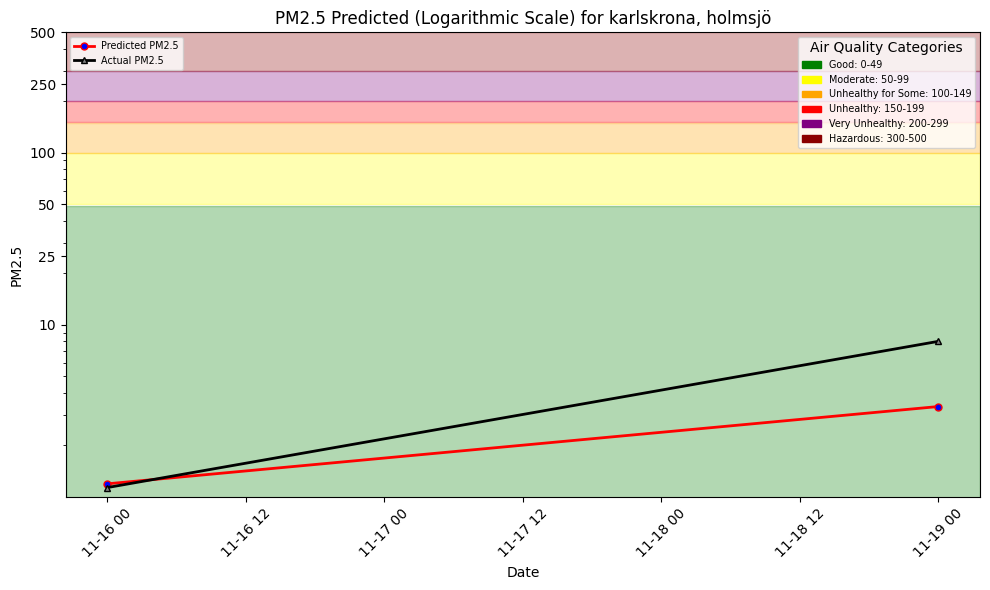

In [19]:
hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [20]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading /Users/hayleychang/Desktop/tmp/mlfs-book/docs/air-quality/assets/img/pm25_forecast.png: 0.000%|     …

Uploading /Users/hayleychang/Desktop/tmp/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day.png: 0.000%|…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1286345/settings/fb/path/Resources/airquality


---